In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('Data/crime_cleaned_modeling.csv')
df.head()

,CrimeCode,Description,Post,District,Neighborhood,Location 1,Date,Year,Month,Day,vio_prop,weapon_used,vacation,StandardizedTime,Hour,Minute
0,0,0,424.0,2,175,"(39.3679000000, -76.5555900000)",2016-06-18,2016,6,18,1,1,True,00:33,0,33
1,0,1,232.0,5,32,"(39.2831500000, -76.5783400000)",2016-06-18,2016,6,18,1,1,True,00:39,0,39
2,8,1,532.0,3,138,"(39.3510400000, -76.6597600000)",2016-06-18,2016,6,18,1,1,True,15:00,15,0
3,6,1,221.0,5,151,"(39.2955600000, -76.5844600000)",2016-06-18,2016,6,18,1,1,True,01:53,1,53
4,5,0,321.0,1,157,"(39.3002700000, -76.5909700000)",2016-06-18,2016,6,18,0,0,True,02:05,2,5


Dropping all the instances where is the yaer is 2016 since the record is only up to June of said year
It will be used for further testing and checking the possiblity of overfitting

In [3]:
df = df[df['Year'] != 2016]
df.drop('Location 1', axis=1, inplace=True)
df.head()

,CrimeCode,Description,Post,District,Neighborhood,Date,Year,Month,Day,vio_prop,weapon_used,vacation,StandardizedTime,Hour,Minute
20073,5,1,923.0,6,135,2015-12-31,2015,12,31,0,0,False,00:01,0,1
20074,0,0,332.0,1,15,2015-12-31,2015,12,31,1,1,False,00:02,0,2
20075,3,0,932.0,6,256,2015-12-31,2015,12,31,0,0,False,01:00,1,0
20076,3,0,842.0,7,36,2015-12-31,2015,12,31,0,0,False,01:01,1,1
20077,0,0,612.0,4,191,2015-12-31,2015,12,31,1,1,False,01:20,1,20


dropping Date and Time

In [4]:
df.drop('StandardizedTime', axis=1, inplace=True)

df.head()

,CrimeCode,Description,Post,District,Neighborhood,Date,Year,Month,Day,vio_prop,weapon_used,vacation,Hour,Minute
20073,5,1,923.0,6,135,2015-12-31,2015,12,31,0,0,False,0,1
20074,0,0,332.0,1,15,2015-12-31,2015,12,31,1,1,False,0,2
20075,3,0,932.0,6,256,2015-12-31,2015,12,31,0,0,False,1,0
20076,3,0,842.0,7,36,2015-12-31,2015,12,31,0,0,False,1,1
20077,0,0,612.0,4,191,2015-12-31,2015,12,31,1,1,False,1,20


In [5]:
#drop NaN and null values
df.dropna(inplace=True)

df.isnull().sum()   

CrimeCode       0
Description     0
Post            0
District        0
Neighborhood    0
Date            0
Year            0
Month           0
Day             0
vio_prop        0
weapon_used     0
vacation        0
Hour            0
Minute          0
dtype: int64

In [6]:
df_model = df.copy()   

In [7]:
Features = ['Description', 'Post', 'District', 'Neighborhood',  'Year', 'Month', 'Day', 'vio_prop', 'weapon_used', 
            'vacation', 'Hour', 'Minute']
print('Full Features: ', Features)

Full Features:  ['Description', 'Post', 'District', 'Neighborhood', 'Year', 'Month', 'Day', 'vio_prop', 'weapon_used', 'vacation', 'Hour', 'Minute']


In [8]:
Target = ['CrimeCode']
print('Target: ', Target)

Target:  ['CrimeCode']


Splitting the data into training and testing 20-80

In [9]:
train_set, test_set = train_test_split(df, 
                                       test_size=0.2, 
                                       train_size=0.8, 
                                       random_state=3)

train_features = train_set[Features]    # Features for training
train_target = train_set[Target]        # Target variable for training
test_features = test_set[Features]      # Features for testing
test_target = test_set[Target]          # Target variable for testing

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Features Set Size : ', train_features.shape)
print('Training Target Set Size   : ', train_target.shape)
print('Test Features Set Size     : ', test_features.shape)
print('Test Target Set Size       : ', test_target.shape)


Feature Set Used    :  ['Description', 'Post', 'District', 'Neighborhood', 'Year', 'Month', 'Day', 'vio_prop', 'weapon_used', 'vacation', 'Hour', 'Minute']
Target Class        :  ['CrimeCode']
Training Features Set Size :  (195377, 12)
Training Target Set Size   :  (195377, 1)
Test Features Set Size     :  (48845, 12)
Test Target Set Size       :  (48845, 1)


In [10]:
original_mapping = {'AGG. ASSAULT': 0, 'ARSON': 1, 'AUTO THEFT': 2, 'BURGLARY': 3, 'HOMICIDE': 4, 'LARCENY': 5, 'ROBBERY': 6, 'SEXUAL ASSAULT': 7, 'SHOOTING': 8}
classes = df['CrimeCode'].unique()

# Invert the mapping to go from numbers to strings
inverted_mapping = {v: k for k, v in original_mapping.items()}

# Now use this inverted mapping to map numbers to strings
string_array = np.array([inverted_mapping.get(item, item) for item in classes])

string_array

array(['LARCENY', 'AGG. ASSAULT', 'BURGLARY', 'ROBBERY', 'AUTO THEFT',
       'HOMICIDE', 'ARSON', 'SEXUAL ASSAULT', 'SHOOTING'], dtype='<U14')

Random Forest

In [11]:
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=train_features, y=train_target)

# Prediction
predicted_results = rf_model.predict(test_features)

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [12]:
accuracy_score_result = accuracy_score(test_target, predicted_results)
recall_score_result = recall_score(test_target, predicted_results, average="weighted")
precision_score_result = precision_score(test_target, predicted_results, average="weighted")
f1_score_result = f1_score(test_target, predicted_results, average='micro')
confusion_matrix_result = confusion_matrix(test_target, predicted_results)

# Printing the Results
print("========== Random Forest Results ==========")
print("Accuracy    : ", accuracy_score_result)
print("Recall      : ", recall_score_result)
print("Precision   : ", precision_score_result)
print("F1 Score    : ", f1_score_result)
print("Confusion Matrix: ")
print(confusion_matrix_result)

========== Random Forest Results ==========
Accuracy    :  0.7158153342204934
Recall      :  0.7158153342204934
Precision   :  0.6859830029962001
F1 Score    :  0.7158153342204934
Confusion Matrix: 
[[13165     0     0     0     0     0   437     0     0]
 [    0     0    15    79     0   168     0     0     0]
 [    0     0   245   210     0  4131     0     0     0]
 [    0     0     8  5513     0  2151     0     0     0]
 [  227     0     0     0     0     0     1     0     0]
 [    0     0   164  2861     0 14579     0     0     0]
 [ 2718     0     0     0     0     0  1462     0     0]
 [  269     0     0     0     0     0    38     0     0]
 [  400     0     0     0     0     0     4     0     0]]


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

================= Classification Report =================

                precision    recall  f1-score   support

       LARCENY       0.78      0.97      0.87     13602
  AGG. ASSAULT       0.00      0.00      0.00       262
      BURGLARY       0.57      0.05      0.10      4586
       ROBBERY       0.64      0.72      0.67      7672
    AUTO THEFT       0.00      0.00      0.00       228
      HOMICIDE       0.69      0.83      0.75     17604
         ARSON       0.75      0.35      0.48      4180
SEXUAL ASSAULT       0.00      0.00      0.00       307
      SHOOTING       0.00      0.00      0.00       404

      accuracy                           0.72     48845
     macro avg       0.38      0.32      0.32     48845
  weighted avg       0.69      0.72      0.67     48845



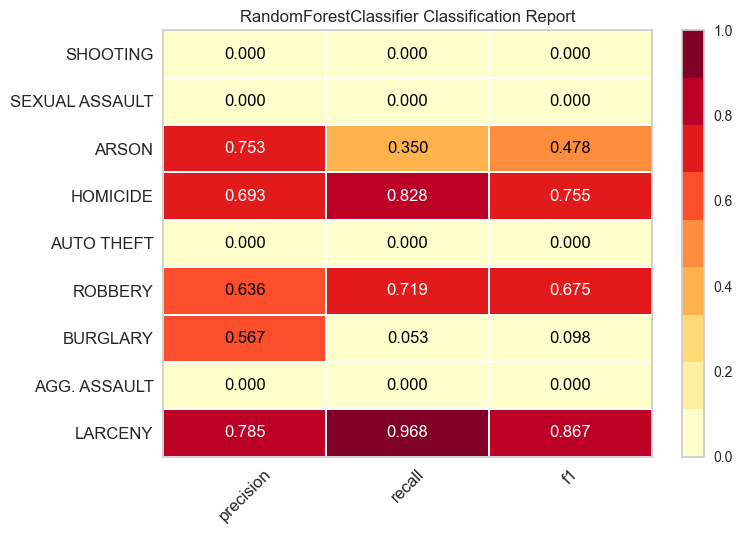

In [13]:
target_names = string_array
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=train_features, y=train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, predicted_results, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [14]:
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=train_features, y=train_target)

# Prediction
predicted_result_nn = nn_model.predict(test_features) 

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
accuracy_score_result = accuracy_score(test_target, predicted_result_nn)
recall_score_result = recall_score(test_target, predicted_result_nn, average="weighted")
precision_score_result = precision_score(test_target, predicted_result_nn, average="weighted")
f1_score_result = f1_score(test_target, predicted_result_nn, average='weighted')

# Printing the Results
print("========== Neural Networks Results ==========")
print("Accuracy    : ", accuracy_score_result)
print("Recall      : ", recall_score_result)
print("Precision   : ", precision_score_result)
print("F1 Score    : ", f1_score_result)
print("Confusion Matrix: ")
print(confusion_matrix_result)

========== Neural Networks Results ==========
Accuracy    :  0.6847988535162248
Recall      :  0.6847988535162248
Precision   :  0.6068540787133635
F1 Score    :  0.6324519516969195
Confusion Matrix: 
[[13165     0     0     0     0     0   437     0     0]
 [    0     0    15    79     0   168     0     0     0]
 [    0     0   245   210     0  4131     0     0     0]
 [    0     0     8  5513     0  2151     0     0     0]
 [  227     0     0     0     0     0     1     0     0]
 [    0     0   164  2861     0 14579     0     0     0]
 [ 2718     0     0     0     0     0  1462     0     0]
 [  269     0     0     0     0     0    38     0     0]
 [  400     0     0     0     0     0     4     0     0]]


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


================= Classification Report =================

                precision    recall  f1-score   support

       LARCENY       0.78      0.97      0.86     13602
  AGG. ASSAULT       0.00      0.00      0.00       262
      BURGLARY       0.00      0.00      0.00      4586
       ROBBERY       0.55      0.67      0.61      7672
    AUTO THEFT       0.00      0.00      0.00       228
      HOMICIDE       0.66      0.78      0.72     17604
         ARSON       0.76      0.32      0.45      4180
SEXUAL ASSAULT       0.00      0.00      0.00       307
      SHOOTING       0.00      0.00      0.00       404

      accuracy                           0.68     48845
     macro avg       0.31      0.30      0.29     48845
  weighted avg       0.61      0.68      0.63     48845



C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: U

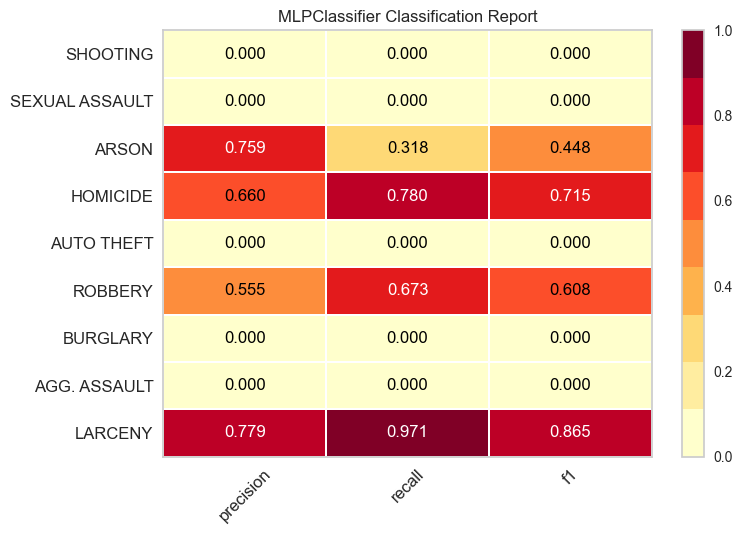

In [16]:
target_names = string_array
visualizer = ClassificationReport(nn_model, classes=target_names)
visualizer.fit(X=train_features, y=train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, predicted_result_nn, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

KNN

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X=train_features, y=train_target)

result_knn = knn_model.predict(test_features) 

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [18]:
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X=train_features, y=train_target)


result_knn = knn_model.predict(test_features)


ac_sc = accuracy_score(test_target, result_knn)
rc_sc = recall_score(test_target, result_knn, average="weighted")
pr_sc = precision_score(test_target, result_knn, average="weighted")
f1_sc = f1_score(test_target, result_knn, average='micro')
confusion_m = confusion_matrix(test_target, result_knn)

print("========== K-Nearest Neighbors Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


========== K-Nearest Neighbors Results ==========
Accuracy    :  0.44233800798444056
Recall      :  0.44233800798444056
Precision   :  0.403678374582554
F1 Score    :  0.4423380079844406
Confusion Matrix: 
[[ 8018     2   405  1097     2  3726   341     1    10]
 [  135     3    16    30     0    75     3     0     0]
 [ 1242     0   484   567     0  2217    76     0     0]
 [ 2051     4   377  1988     0  3137   112     0     3]
 [  159     0     3    15     0    41     9     0     1]
 [ 3708     0   859  2025     1 10815   195     1     0]
 [ 2115     0   134   321     1  1312   297     0     0]
 [  189     0     9    21     0    79     9     0     0]
 [  291     0    13    16     1    63    19     0     1]]


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


================= Classification Report =================

                precision    recall  f1-score   support

       LARCENY       0.45      0.59      0.51     13602
  AGG. ASSAULT       0.33      0.01      0.02       262
      BURGLARY       0.21      0.11      0.14      4586
       ROBBERY       0.33      0.26      0.29      7672
    AUTO THEFT       0.00      0.00      0.00       228
      HOMICIDE       0.50      0.61      0.55     17604
         ARSON       0.28      0.07      0.11      4180
SEXUAL ASSAULT       0.00      0.00      0.00       307
      SHOOTING       0.07      0.00      0.00       404

      accuracy                           0.44     48845
     macro avg       0.24      0.18      0.18     48845
  weighted avg       0.40      0.44      0.41     48845



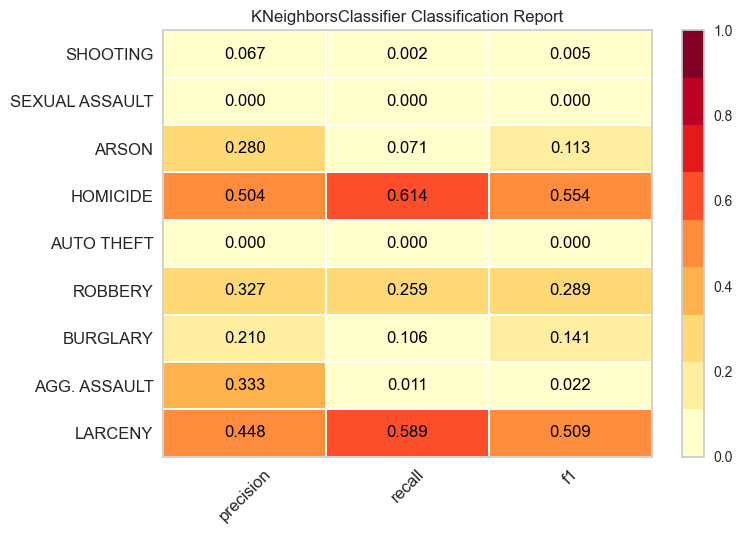

In [19]:
target_names = string_array
visualizer = ClassificationReport(knn_model, classes=target_names)
visualizer.fit(train_features, train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, result_knn, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

Merging the minority observations with the majority observations & dropping 'ARSON' 
SEXUAL, HOMICIDE, SHOOTING --> AGG. ASSAULT
AUTO THEFT --> ROBBERY

In [20]:
mapping = {'AGG. ASSAULT': 0, 'ARSON': 1, 'AUTO THEFT': 2, 'BURGLARY': 3, 'HOMICIDE': 4, 'LARCENY': 5, 'ROBBERY': 6, 
           'SEXUAL ASSAULT': 7, 'SHOOTING': 8}

inverse_mapping = {v: k for k, v in mapping.items()}

df['CrimeCode'] = df['CrimeCode'].map(inverse_mapping)

CrimeCode
LARCENY           88032
AGG. ASSAULT      68167
BURGLARY          38737
AUTO THEFT        22598
ROBBERY           20556
SHOOTING           2155
SEXUAL ASSAULT     1460
ARSON              1313
HOMICIDE           1204
dtype: int64


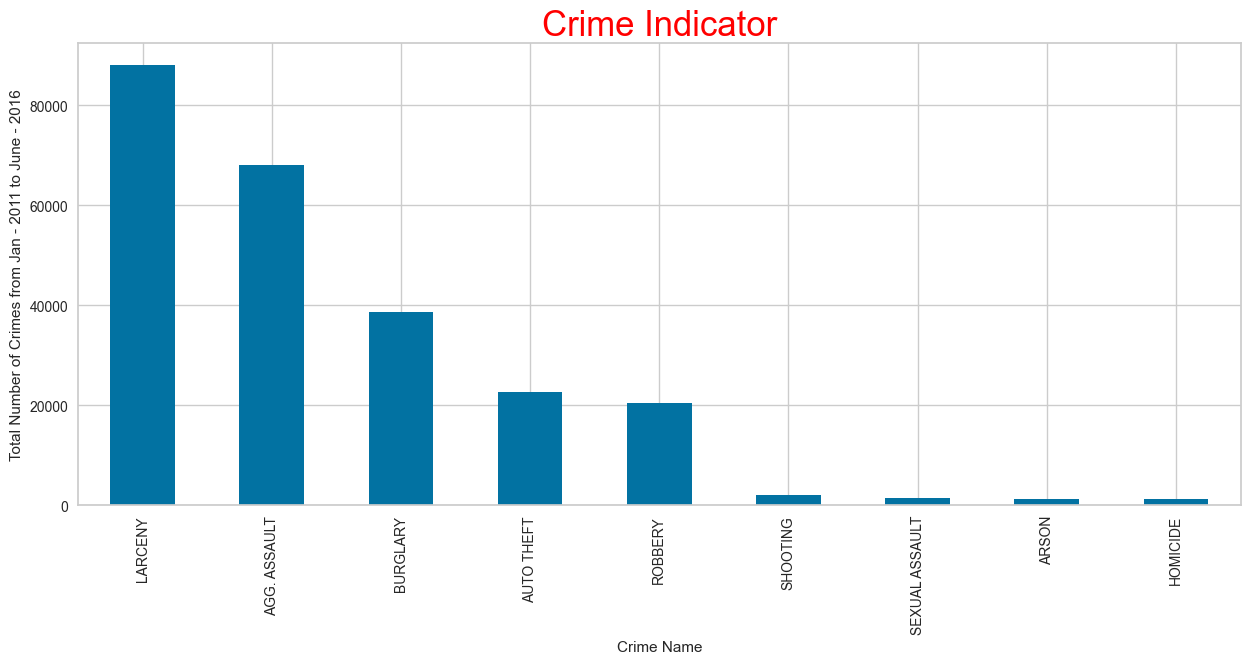

In [21]:
crime_indicator = df.groupby('CrimeCode').size().sort_values(ascending=False)

print(crime_indicator)

plt.subplots(figsize = (15, 6))
ax = crime_indicator.plot.bar()
ax.set_xlabel('Crime Name')
ax.set_ylabel('Total Number of Crimes from Jan - 2011 to June - 2016')
ax.set_title('Crime Indicator', color = 'red', fontsize=25)
plt.show()

In [22]:
categories = ['LARCENY', 'AGG. ASSAULT', 'BURGLARY', 'AUTO THEFT', 
              'ROBBERY', 'SHOOTING', 'SEXUAL ASSAULT', 
              'ARSON', 'HOMICIDE']

# Map crimes to AGG. ASSAULT
crimes_to_agg = ['HOMICIDE','SEXUAL ASSAULT', 'SHOOTING']
df.loc[df['CrimeCode'].isin(crimes_to_agg), 'CrimeCode'] = 'AGG. ASSAULT'

# Map AUTO THEFT to ROBBERY 
df.loc[df['CrimeCode'] == 'AUTO THEFT', 'CrimeCode'] = 'ROBBERY'

In [23]:
df = df[df['CrimeCode'] != 'ARSON']

CrimeCode
LARCENY         88032
AGG. ASSAULT    72986
ROBBERY         43154
BURGLARY        38737
dtype: int64


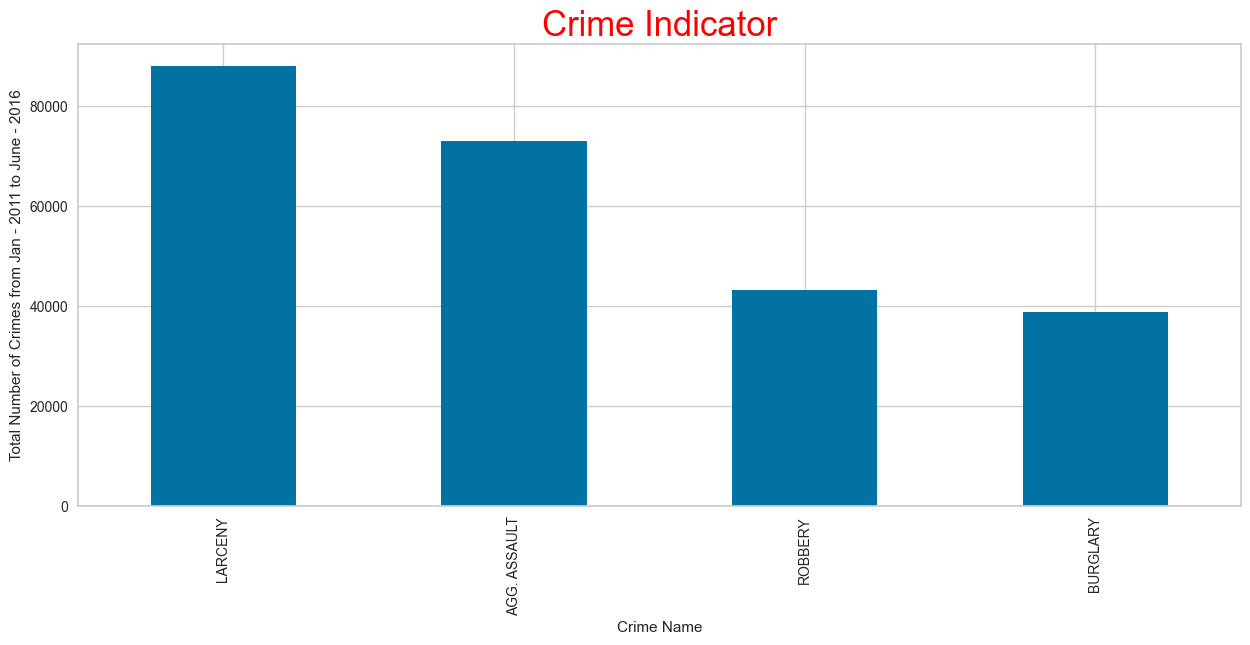

In [24]:
crime_indicator = df.groupby('CrimeCode').size().sort_values(ascending=False)

print(crime_indicator)

plt.subplots(figsize = (15, 6))
ax = crime_indicator.plot.bar()
ax.set_xlabel('Crime Name')
ax.set_ylabel('Total Number of Crimes from Jan - 2011 to June - 2016')
ax.set_title('Crime Indicator', color = 'red', fontsize=25)
plt.show()

In [30]:
label_encoders = {}

categorical_cols = ['CrimeCode']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
    label_encoders[col] = le
    
for col, le in label_encoders.items():
    classes = le.classes_
    encoded_values = le.transform(classes)


    mapping = dict(zip(classes, encoded_values))
    print(f"Mapping for '{col}': {mapping}")

Mapping for 'CrimeCode': {'AGG. ASSAULT': 0, 'BURGLARY': 1, 'LARCENY': 2, 'ROBBERY': 3}


In [31]:
train_set, test_set = train_test_split(df, 
                                       test_size=0.2, 
                                       train_size=0.8, 
                                       random_state=3)

train_features = train_set[Features]    # Features for training
train_target = train_set[Target]        # Target variable for training
test_features = test_set[Features]      # Features for testing
test_target = test_set[Target]          # Target variable for testing

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Features Set Size : ', train_features.shape)
print('Training Target Set Size   : ', train_target.shape)
print('Test Features Set Size     : ', test_features.shape)
print('Test Target Set Size       : ', test_target.shape)


Feature Set Used    :  ['Description', 'Post', 'District', 'Neighborhood', 'Year', 'Month', 'Day', 'vio_prop', 'weapon_used', 'vacation', 'Hour', 'Minute']
Target Class        :  ['CrimeCode']
Training Features Set Size :  (194327, 12)
Training Target Set Size   :  (194327, 1)
Test Features Set Size     :  (48582, 12)
Test Target Set Size       :  (48582, 1)


In [32]:
original_mapping = {'AGG. ASSAULT': 0, 'BURGLARY': 1, 'LARCENY': 2, 'ROBBERY': 3}
classes = df['CrimeCode'].unique()

# Invert the mapping to go from numbers to strings
inverted_mapping = {v: k for k, v in original_mapping.items()}

# Now use this inverted mapping to map numbers to strings
string_array = np.array([inverted_mapping.get(item, item) for item in classes])

string_array

array(['LARCENY', 'AGG. ASSAULT', 'BURGLARY', 'ROBBERY'], dtype='<U12')

In [33]:
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=train_features, y=train_target)

# Prediction
predicted_results = rf_model.predict(test_features)

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [34]:
accuracy_score_result = accuracy_score(test_target, predicted_results)
recall_score_result = recall_score(test_target, predicted_results, average="weighted")
precision_score_result = precision_score(test_target, predicted_results, average="weighted")
f1_score_result = f1_score(test_target, predicted_results, average='micro')
confusion_matrix_result = confusion_matrix(test_target, predicted_results)

# Printing the Results
print("========== Random Forest Results ==========")
print("Accuracy    : ", accuracy_score_result)
print("Recall      : ", recall_score_result)
print("Precision   : ", precision_score_result)
print("F1 Score    : ", f1_score_result)
print("Confusion Matrix: ")
print(confusion_matrix_result)

========== Random Forest Results ==========
Accuracy    :  0.8297311761557778
Recall      :  0.8297311761557778
Precision   :  0.8363234438848867
F1 Score    :  0.829731176155778
Confusion Matrix: 
[[13772     0     0   664]
 [    0  5632  2065     0]
 [    0  2997 14719     0]
 [ 2546     0     0  6187]]


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


================= Classification Report =================

              precision    recall  f1-score   support

     LARCENY       0.84      0.95      0.90     14436
AGG. ASSAULT       0.65      0.73      0.69      7697
    BURGLARY       0.88      0.83      0.85     17716
     ROBBERY       0.90      0.71      0.79      8733

    accuracy                           0.83     48582
   macro avg       0.82      0.81      0.81     48582
weighted avg       0.84      0.83      0.83     48582



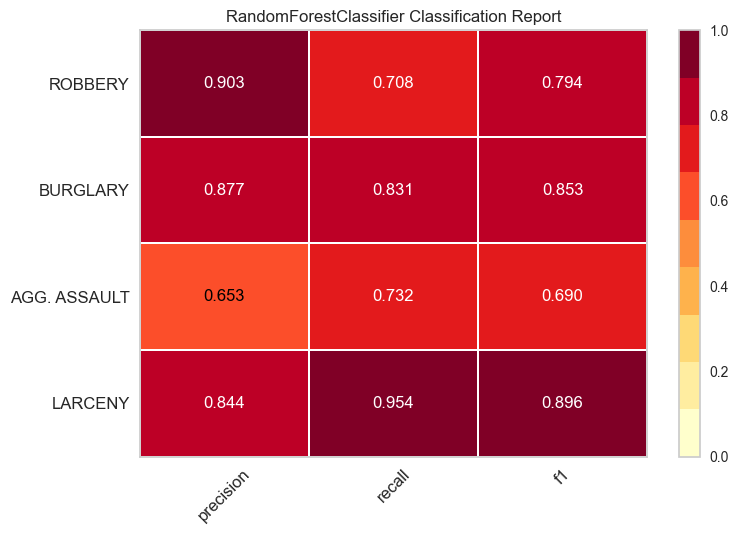

In [35]:
target_names = string_array
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=train_features, y=train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, predicted_results, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [36]:
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=train_features, y=train_target)

# Prediction
predicted_result_nn = nn_model.predict(test_features) 

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
accuracy_score_result = accuracy_score(test_target, predicted_result_nn)
recall_score_result = recall_score(test_target, predicted_result_nn, average="weighted")
precision_score_result = precision_score(test_target, predicted_result_nn, average="weighted")
f1_score_result = f1_score(test_target, predicted_result_nn, average='weighted')

# Printing the Results
print("========== Neural Networks Results ==========")
print("Accuracy    : ", accuracy_score_result)
print("Recall      : ", recall_score_result)
print("Precision   : ", precision_score_result)
print("F1 Score    : ", f1_score_result)
print("Confusion Matrix: ")
print(confusion_matrix_result)

========== Neural Networks Results ==========
Accuracy    :  0.7764810011938578
Recall      :  0.7764810011938578
Precision   :  0.844050005490054
F1 Score    :  0.7798570717805696
Confusion Matrix: 
[[13772     0     0   664]
 [    0  5632  2065     0]
 [    0  2997 14719     0]
 [ 2546     0     0  6187]]


================= Classification Report =================

              precision    recall  f1-score   support

     LARCENY       0.84      0.95      0.89     14436
AGG. ASSAULT       0.50      0.95      0.66      7697
    BURGLARY       0.96      0.59      0.73     17716
     ROBBERY       0.90      0.71      0.79      8733

    accuracy                           0.78     48582
   macro avg       0.80      0.80      0.77     48582
weighted avg       0.84      0.78      0.78     48582



C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


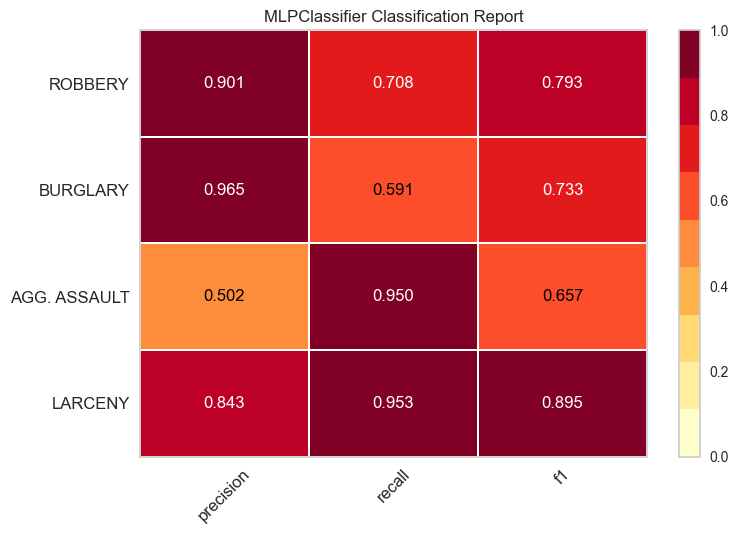

In [38]:
target_names = string_array
visualizer = ClassificationReport(nn_model, classes=target_names)
visualizer.fit(X=train_features, y=train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, predicted_result_nn, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [42]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X=train_features, y=train_target)


result_knn = knn_model.predict(test_features)


ac_sc = accuracy_score(test_target, result_knn)
rc_sc = recall_score(test_target, result_knn, average="weighted")
pr_sc = precision_score(test_target, result_knn, average="weighted")
f1_sc = f1_score(test_target, result_knn, average='micro')
confusion_m = confusion_matrix(test_target, result_knn)

print("========== K-Nearest Neighbors Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


========== K-Nearest Neighbors Results ==========
Accuracy    :  0.4688567782306204
Recall      :  0.4688567782306204
Precision   :  0.4448848654635188
F1 Score    :  0.4688567782306204
Confusion Matrix: 
[[ 8800  1105  3360  1171]
 [ 2159  2054  3023   461]
 [ 3892  2083 10709  1032]
 [ 3419   916  3183  1215]]


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


================= Classification Report =================

              precision    recall  f1-score   support

     LARCENY       0.48      0.61      0.54     14436
AGG. ASSAULT       0.33      0.27      0.30      7697
    BURGLARY       0.53      0.60      0.56     17716
     ROBBERY       0.31      0.14      0.19      8733

    accuracy                           0.47     48582
   macro avg       0.41      0.41      0.40     48582
weighted avg       0.44      0.47      0.45     48582



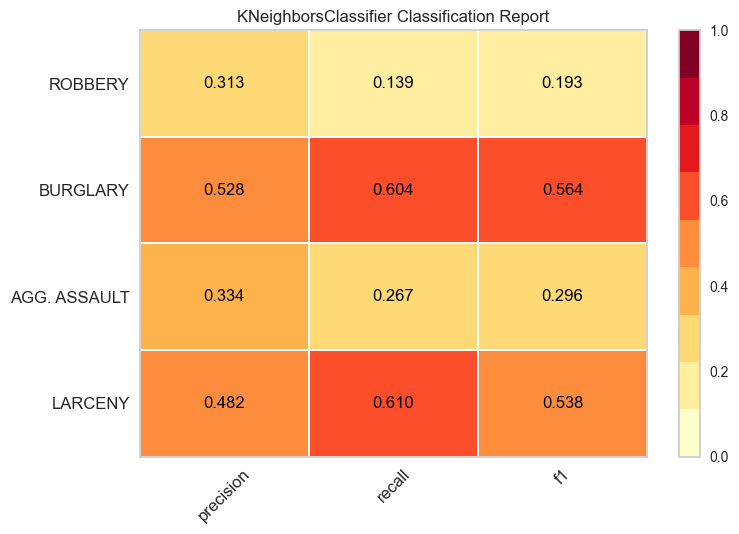

In [43]:
target_names = string_array
visualizer = ClassificationReport(knn_model, classes=target_names)
visualizer.fit(train_features, train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, result_knn, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

Applying SMOTE

In [44]:
train_set, test_set = train_test_split(df, test_size=0.2, train_size=0.8, random_state=3)

train_features = train_set[Features]    # Features for training
train_target = train_set[Target]        # Target variable for training
test_features = test_set[Features]      # Features for testing
test_target = test_set[Target]          # Target variable for testing

# Applying SMOTE to the training data
smote = SMOTE(random_state=3)
train_features_smote, train_target_smote = smote.fit_resample(train_features, train_target)

# Printing the details
print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Original Training Features Set Size : ', train_features.shape)
print('Original Training Target Set Size   : ', train_target.shape)
print('SMOTE Training Features Set Size    : ', train_features_smote.shape)
print('SMOTE Training Target Set Size      : ', train_target_smote.shape)
print('Test Features Set Size              : ', test_features.shape)
print('Test Target Set Size                : ', test_target.shape)

Feature Set Used    :  ['Description', 'Post', 'District', 'Neighborhood', 'Year', 'Month', 'Day', 'vio_prop', 'weapon_used', 'vacation', 'Hour', 'Minute']
Target Class        :  ['CrimeCode']
Original Training Features Set Size :  (194327, 12)
Original Training Target Set Size   :  (194327, 1)
SMOTE Training Features Set Size    :  (281264, 12)
SMOTE Training Target Set Size      :  (281264, 1)
Test Features Set Size              :  (48582, 12)
Test Target Set Size                :  (48582, 1)


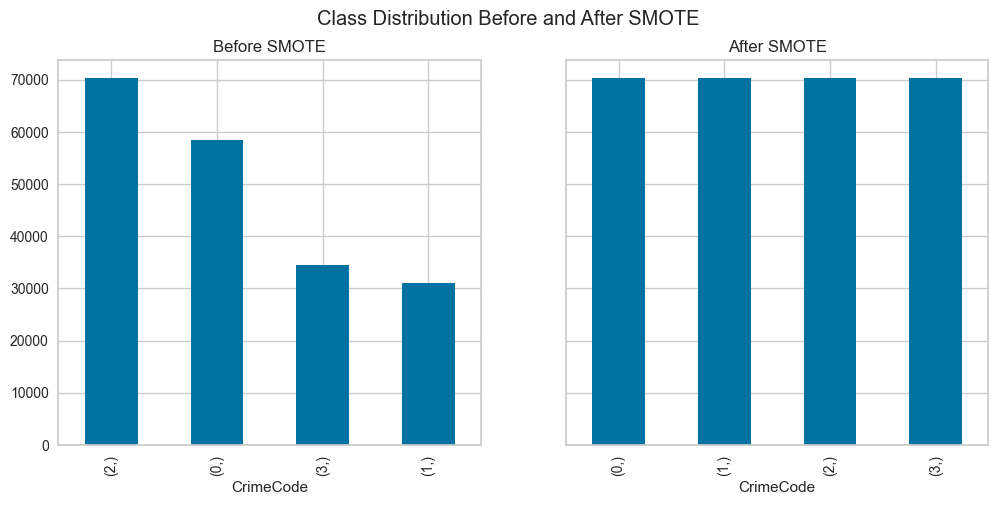

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Class Distribution Before and After SMOTE')

# Before SMOTE
train_target.value_counts().plot(kind='bar', ax=axes[0], title='Before SMOTE')

# After SMOTE
train_target_smote.value_counts().plot(kind='bar', ax=axes[1], title='After SMOTE')

plt.show()

In [47]:
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=train_features, y=train_target)

# Prediction
predicted_results = rf_model.predict(test_features)

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [48]:
accuracy_score_result = accuracy_score(test_target, predicted_results)
recall_score_result = recall_score(test_target, predicted_results, average="weighted")
precision_score_result = precision_score(test_target, predicted_results, average="weighted")
f1_score_result = f1_score(test_target, predicted_results, average='micro')
confusion_matrix_result = confusion_matrix(test_target, predicted_results)

# Printing the Results
print("========== Random Forest Results ==========")
print("Accuracy    : ", accuracy_score_result)
print("Recall      : ", recall_score_result)
print("Precision   : ", precision_score_result)
print("F1 Score    : ", f1_score_result)
print("Confusion Matrix: ")
print(confusion_matrix_result)

========== Random Forest Results ==========
Accuracy    :  0.8296488411345766
Recall      :  0.8296488411345766
Precision   :  0.835787522576127
F1 Score    :  0.8296488411345766
Confusion Matrix: 
[[13778     0     0   658]
 [    0  5579  2118     0]
 [    0  2959 14757     0]
 [ 2541     0     0  6192]]


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


================= Classification Report =================

              precision    recall  f1-score   support

     LARCENY       0.84      0.95      0.90     14436
AGG. ASSAULT       0.65      0.72      0.69      7697
    BURGLARY       0.87      0.83      0.85     17716
     ROBBERY       0.90      0.71      0.79      8733

    accuracy                           0.83     48582
   macro avg       0.82      0.81      0.81     48582
weighted avg       0.84      0.83      0.83     48582



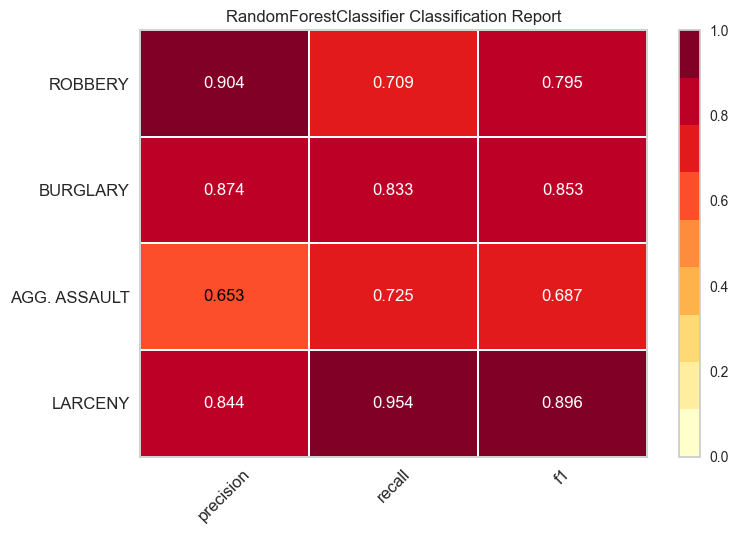

In [49]:
target_names = string_array
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=train_features, y=train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, predicted_results, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [50]:
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=train_features, y=train_target)

# Prediction
predicted_result_nn = nn_model.predict(test_features) 

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
accuracy_score_result = accuracy_score(test_target, predicted_result_nn)
recall_score_result = recall_score(test_target, predicted_result_nn, average="weighted")
precision_score_result = precision_score(test_target, predicted_result_nn, average="weighted")
f1_score_result = f1_score(test_target, predicted_result_nn, average='weighted')

# Printing the Results
print("========== Neural Networks Results ==========")
print("Accuracy    : ", accuracy_score_result)
print("Recall      : ", recall_score_result)
print("Precision   : ", precision_score_result)
print("F1 Score    : ", f1_score_result)
print("Confusion Matrix: ")
print(confusion_matrix_result)

========== Neural Networks Results ==========
Accuracy    :  0.7764810011938578
Recall      :  0.7764810011938578
Precision   :  0.844050005490054
F1 Score    :  0.7798570717805696
Confusion Matrix: 
[[13778     0     0   658]
 [    0  5579  2118     0]
 [    0  2959 14757     0]
 [ 2541     0     0  6192]]


================= Classification Report =================

              precision    recall  f1-score   support

     LARCENY       0.84      0.95      0.89     14436
AGG. ASSAULT       0.50      0.95      0.66      7697
    BURGLARY       0.96      0.59      0.73     17716
     ROBBERY       0.90      0.71      0.79      8733

    accuracy                           0.78     48582
   macro avg       0.80      0.80      0.77     48582
weighted avg       0.84      0.78      0.78     48582



C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


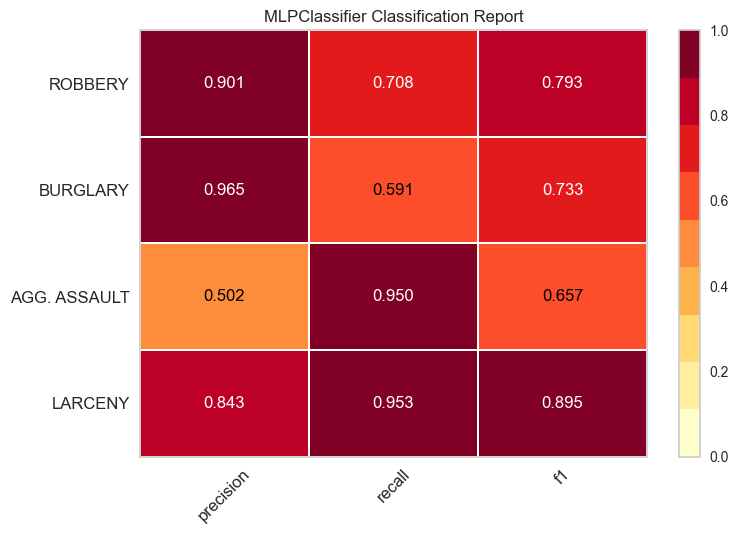

In [52]:
target_names = string_array
visualizer = ClassificationReport(nn_model, classes=target_names)
visualizer.fit(X=train_features, y=train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, predicted_result_nn, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [57]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X=train_features, y=train_target)


result_knn = knn_model.predict(test_features)


ac_sc = accuracy_score(test_target, result_knn)
rc_sc = recall_score(test_target, result_knn, average="weighted")
pr_sc = precision_score(test_target, result_knn, average="weighted")
f1_sc = f1_score(test_target, result_knn, average='micro')
confusion_m = confusion_matrix(test_target, result_knn)

print("========== K-Nearest Neighbors Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


========== K-Nearest Neighbors Results ==========
Accuracy    :  0.4688567782306204
Recall      :  0.4688567782306204
Precision   :  0.4448848654635188
F1 Score    :  0.4688567782306204
Confusion Matrix: 
[[ 8800  1105  3360  1171]
 [ 2159  2054  3023   461]
 [ 3892  2083 10709  1032]
 [ 3419   916  3183  1215]]


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


================= Classification Report =================

              precision    recall  f1-score   support

     LARCENY       0.48      0.61      0.54     14436
AGG. ASSAULT       0.33      0.27      0.30      7697
    BURGLARY       0.53      0.60      0.56     17716
     ROBBERY       0.31      0.14      0.19      8733

    accuracy                           0.47     48582
   macro avg       0.41      0.41      0.40     48582
weighted avg       0.44      0.47      0.45     48582



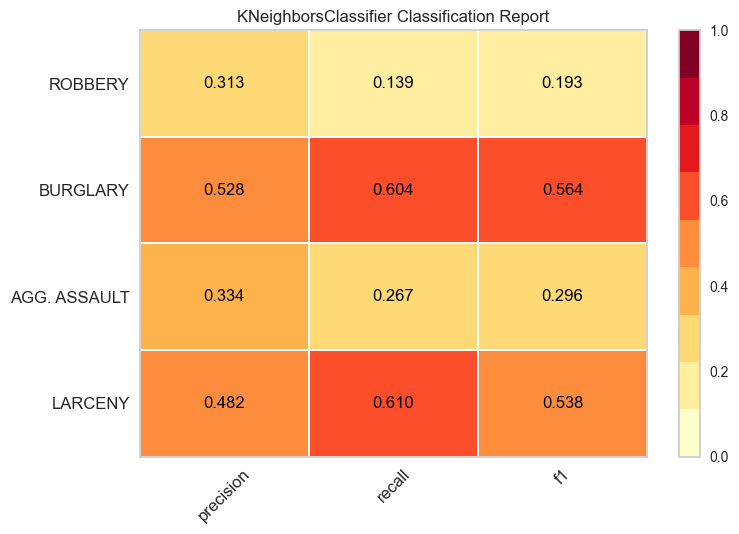

In [54]:
target_names = string_array
visualizer = ClassificationReport(knn_model, classes=target_names)
visualizer.fit(train_features, train_target)     # Fit the training data to the visualizer
visualizer.score(test_features, test_target)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(test_target, result_knn, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

Applying SMOTE did not meet the expectations

Applying cross-validation 5-Folds

In [58]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier()

cv_scores = cross_val_score(rf_model, train_features, train_target, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores: ", cv_scores)
print("Mean CV Accuracy: ", cv_scores.mean())

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

Cross-Validation Scores:  [0.83625791 0.83913961 0.83519876 0.84001029 0.83622797]
Mean CV Accuracy:  0.8373669090568908


The purpose of using cross_val_score is to assess how well the model generalizes to unseen data. It divides the data into (5) folds, trains the model on (4) folds, and tests it on the remaining fold. This process is repeated (5) times, each time with a different fold used as the test set. The resulting scores provide a more robust estimate of the model's performance than a single train/test split, as it averages performance across multiple splits.

A very subtle improvemnt is observed

Tetsing GridSearchCV for hyperparameter tuning, GridSearchCV performs cross-validation to determine the best hyperparameters from the specified param_grid.The model is implicitly trained multiple times during this process, on different subsets of the data. The best_model is the RandomForest model with the best hyperparameters found through this cross-validation process.

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30]
}

rf_model = RandomForestClassifier()


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')


grid_search.fit(train_features, train_target)


best_model = grid_search.best_estimator_


predicted_results = best_model.predict(test_features)

accuracy_score_result = accuracy_score(test_target, predicted_results)
recall_score_result = recall_score(test_target, predicted_results, average="weighted")
precision_score_result = precision_score(test_target, predicted_results, average="weighted")
f1_score_result = f1_score(test_target, predicted_results, average='micro')
confusion_matrix_result = confusion_matrix(test_target, predicted_results)

# Printing the Results
print("========== Random Forest Results ==========")
print("Accuracy    : ", accuracy_score_result)
print("Recall      : ", recall_score_result)
print("Precision   : ", precision_score_result)
print("F1 Score    : ", f1_score_result)
print("Confusion Matrix: ")
print(confusion_matrix_result)


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

========== Random Forest Results ==========
Accuracy    :  0.8391997035939237
Recall      :  0.8391997035939237
Precision   :  0.843446077107401
F1 Score    :  0.8391997035939237
Confusion Matrix: 
[[13738     0     0   698]
 [    0  5569  2128     0]
 [    0  2828 14888     0]
 [ 2158     0     0  6575]]
